In [1]:
#Checks system information in linux based system, ignore this block 
!uname -a
!lsb_release -a

"uname" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"lsb_release" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## En esta primera sección hacemos una limpieza de datos para obtener matrices de frecuencias (Term-Document Matrixes) a partir de los discursos de estado de la nación, lo que será necesario para una buena visualización. Estas matrices son la pieza fundamental para el análisis de texto, y consisten en matrices que guardan la frecuencia en la cual cada palabra es mencionada en un texto.

In [2]:
# Cargamos librerías para leer los documentos y crear las matrices de frecuencias
import glob 
import os
import scipy
import numpy as np
import pandas as pd

### Los datos crudos son un conjunto de 89 archivos de texto con los discursos de estado de la nación entre 1926 y 2015, con excepción de 1970. 
### Después de muchos problemas con la lectura de datos, se observa que hasta el año 1989 tienen encoding utf8. Desde 1990 el encoding no es reconocido pero se puede reconocer con ISO-8859-1.

In [3]:
#speeches are in corpus folder
filepath = '..\\corpus\\*'
file_list = glob.glob(filepath)

corpus = []

for file_path in file_list:
    with open(file_path, encoding = "ISO-8859-1") as f_input:
        corpus.append(f_input.read())

## We should have 90 speeches since 1926

In [4]:
len(corpus)

90

### Primero obtenemos un set de stopwords en español, las que deben ser removidas de los discursos. Si vemos el primero, notamos que hay muchas de estas palabras como 'del', 'y', 'la', que deben ser removidas.

In [5]:
corpus[0]

'ï»¿. Conciudadanos del Senado y de la CÃ¡mara de Diputados: \n. En cumplimiento de lo ordenado por el artÃ\xadculo cincuenta y seis de la ConstituciÃ³n PolÃ\xadtica, tengo el honor de daros cuenta del estado administrativo y polÃ\xadtico de la NaciÃ³n.\n. Al asumir el mando supremo el veintitrÃ©s de Diciembre del aÃ±o Ãºltimo, la RepÃºblica se encontraba en situaciÃ³n delicada y extraordinaria. \n. Acontecimientos mÃºltiples habÃ\xadan sacudido violentamente nuestras instituciones; se habÃ\xada modificado nuestra Carta Fundamental; y acababan de ser elegidos, en voto popular, los representante de los Poderes Ejecutivo y Legislativo. \n. Se advertÃ\xada una impresiÃ³n de inquietud, que se exaltaba al calor de las desconfianzas y recelos que los Ãºltimos sucesos habÃ\xadan producido. \n. Causas econÃ³micas diversas habÃ\xadan creado, por otra parte, dificultades graves al Erario PÃºblico, que hacÃ\xadan penoso el cumplimiento de los compromisos del Estado y que acentuaban el malestar po

In [6]:
#se puede comentar afuera todo este bloque de código, no es parte del análisis final. Pero sirve para notar que las stopwords
#del módulo stop_words no son suficientes para nuestro análisis

#from stop_words import get_stop_words 
#stop_words = get_stop_words('spanish')
#len(stop_words)

### La cantidad de palabras en stopwords de la libraría stop_words es 308, lo que es algo bajo y al utilizarla en el procesamiento de datos se obtienen muchas palabras que entregan poca información como números. Por esto se lee un archivo con una mejor versión de stopwords en español.

In [7]:
stop_words_es = open('../data/stopwords.txt', encoding = 'ISO-8859-1') 
stop_words_es = [line.split() for line in stop_words_es.readlines()]
len(stop_words_es)

673

### Como se puede ver, hay 673 palabras en este último set, lo que permitirá obtener mejores resultados. Como el formato no es el requerido, lo cambiamos a una lista de python. 

In [8]:
stop_es = []
for i in range(0,len(stop_words_es)):
    stop_es.append(stop_words_es[i][0])

### Agregamos algunas palabras que se usan en discursos de estado de la nación que no aportan para efectos del análisis usado en esta etapa.

In [9]:
extra_words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']
stop_es.extend(extra_words)

### También removemos todos los números escritos como números (1-9) del corpus ya que tampoco nos dan información relevante para los algoritmos que aplicaremos.

In [10]:
for i in range(0, 90): corpus[i] = ''.join(c for c in corpus[i] if not c.isnumeric())

### Ahora pasamos a tokenizar los textos (separar por palabras), obtener el vocabulario completo usado y las matrices de frecuencia. Para esto usamos la función CountVectorizer de sklearn.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(input=corpus, encoding = "utf-8", strip_accents='unicode', stop_words= stop_es)

dtm = vectorizer.fit_transform(corpus)  # matriz de frecuencia para todos los discursos

vocab = vectorizer.get_feature_names()  # lista de vocabulario usado

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aca', 'afirmo', 'agrego', 'algun', 'alla', 'anadio', 'aseguro', 'comento', 'considero', 'dejo', 'estara', 'etcetera', 'explico', 'expreso', 'habian', 'habra', 'indico', 'jamas', 'llego', 'manana', 'manifesto', 'menciono', 'millon', 'muchisima', 'muchisimas', 'muchisimo', 'muchisimos', 'podra', 'podran', 'proximos', 'quedo', 'realizo', 'senalo', 'seran', 'seria', 'tendra', 'tendran', 'tenia', 'traves', 'ultima', 'ultimas', 'ultimos'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
type(dtm)

scipy.sparse.csr.csr_matrix

### Como se puede ver, la matriz de frecuencia es un objeto de clase csr_matrix de scipy. Para trabajar con los datos será más conveniente convertir la matriz a un array de numpy, lo que se hace a continuación.  

In [13]:
dtm = dtm.toarray()
vocab = np.array(vocab)
type(dtm)

numpy.ndarray

### También construimos un arreglo sumando los discursos para cada periodo presidencial. Esto concluye la parte de data cleaning.

### Ahora identificamos los discursos por número de presidente

In [14]:
(years, vocabulary_length) = dtm.shape

In [15]:
dtm_presidents = np.zeros((18, vocabulary_length))
dtm_presidents[0] = dtm[0]+dtm[1] #26-27
dtm_presidents[1] = dtm[2]+dtm[5] #28-31
dtm_presidents[2] = dtm[6] #32
dtm_presidents[3] = dtm[7]+dtm[12] #33-38
dtm_presidents[4] = dtm[13]+dtm[15] #39-41
dtm_presidents[5] = dtm[16]+dtm[20] #42-46
dtm_presidents[6] = dtm[21]+dtm[26] #47-52
dtm_presidents[7] = dtm[27]+dtm[32] #53-58
dtm_presidents[8] = dtm[33]+dtm[38] #59-64
dtm_presidents[9] = dtm[39]+dtm[44] #65-70 
dtm_presidents[10] = dtm[45]+dtm[47] #71-73
dtm_presidents[11] = dtm[48]+dtm[63] #74-89
dtm_presidents[12] = dtm[64]+dtm[67] #90-93
dtm_presidents[13] = dtm[68]+dtm[73] #94-99
dtm_presidents[14] = dtm[74]+dtm[79] #00-05
dtm_presidents[15] = dtm[80]+dtm[83] #06-09
dtm_presidents[16] = dtm[84]+dtm[87] #10-13
dtm_presidents[17] = dtm[88]+dtm[89] #14-15

## A continuación como análisis inicial buscamos una medida de distancia entre discursos. La similitud del coseno es ideal como medida de similitud vectorial. Esto permitirá ubicar cada discurso en un plano cartesiano y hacer comparaciones de acuerdo a la frecuencia de palabras utilizadas. 

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(dtm)

### Ubicamos los discursos en un plano para visualizar la distancia entre ellos.

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  

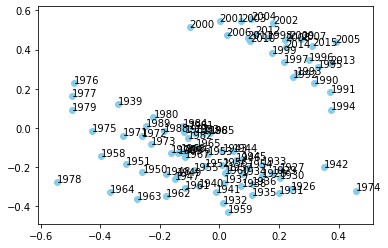

In [18]:
xs, ys = pos[:, 0], pos[:, 1]
filepath = '..\\corpus\\*'
file_list = glob.glob(filepath)
names = [os.path.basename(fn).replace('*', '') for fn in file_list]

for x, y, name in zip(xs, ys, sorted(names)):
    color = 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)


plt.savefig('../results/distance.png', dpi = 600)
plt.show()

### Como tenemos demasiada información en la figura, hacemos lo mismo para periodos presidenciales. Para esto necesitamos una lista con los nombres de los presidentes, la que tenemos en presidents_names.txt

In [19]:
aux = open('../data/presidents_names.txt', encoding = 'ISO-8859-1') 
aux = [line.split() for line in aux.readlines()]
names_presidents = []
for i in range(0,len(aux)):
    names_presidents.append(aux[i][0])

In [20]:
names_presidents

['Figueroa',
 'Ibañez_I',
 'Montero',
 'Alessandri',
 'Aguirre',
 'Rios',
 'Gonzalez',
 'Ibañez_II',
 'Alessandri',
 'Frei_M',
 'Allende',
 'Pinochet',
 'Aylwin',
 'Frei_RT',
 'Lagos',
 'Bachelet_I',
 'Piñera',
 'Bachelet_II']

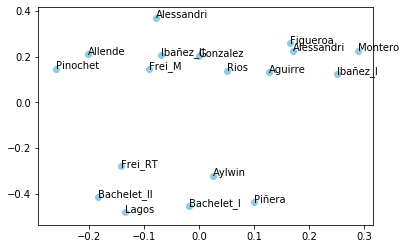

In [21]:
dist_2 = 1 - cosine_similarity(dtm_presidents)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist_2)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, names_presidents):
    color = 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)


plt.savefig('../results/distanceByPresident.png', dpi = 600)
plt.show()

### Es importante no considerar la posición respecto a un eje como una medida de tendencia política, lo único que nos dice el gráfico es la similitud entre presidentes según la frecuencia de las palabras usadas. Las que evidentemente pueden usarse en contextos muy distintos. Interesantemente, se puede ver un cluster de los presidentes desde la vuelta a la democracia en el sector sur este de la figura. 


### Convertimos el arreglo en un data frame de pandas, lo que permitira hacer un mayor análisis. 

In [22]:
dtm = dtm.transpose()
dtm_pandas = pd.DataFrame(dtm)
index_corpus = []
for x in range(1926, 2016):
    index_corpus.append(x)
dtm_pandas.columns = index_corpus
vocab_df = pd.DataFrame(vocab)
dtm_pandas['words'] = vocab_df
dtm_pandas.to_csv('../results/dtm.csv') #guardamos el dataframe 

In [23]:
dtm_pandas.head(5)

,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,words
0,20,30,30,69,96,81,12,57,184,149,...,0,0,0,0,0,0,0,0,0,aa
1,1,2,1,1,3,0,2,0,6,6,...,0,0,0,0,0,0,0,0,0,aaon
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aaonan
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aba
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,abajo


### Veamos algunos estadísticos descriptivos del dataframe. Eliminamos los que no dicen mucho en este caso, por ejemplo, todos los discursos tienen observaciones para cada palabra, aunque esta sea de frecuencia cero. Por lo que no dice nada el conteo de observaciones por variable.

In [24]:
stats = dtm_pandas.describe()
stats = stats.drop(stats.index[[0,3,4,5,6]])
stats

,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
mean,0.066404,0.136893,0.098276,0.194454,0.215721,0.161350,0.055546,0.250812,0.492053,0.255345,...,0.129869,0.176713,0.233714,0.176824,0.208221,0.175509,0.213006,0.170053,0.223108,0.192607
std,0.528293,0.942035,0.749812,1.365178,1.514798,1.157133,0.417363,1.624985,3.118784,1.851345,...,0.819557,1.083980,1.439338,1.032475,1.202856,1.003885,1.195399,1.010891,1.418601,1.237551
max,34.000000,72.000000,50.000000,81.000000,96.000000,81.000000,21.000000,132.000000,188.000000,149.000000,...,40.000000,77.000000,111.000000,53.000000,46.000000,55.000000,54.000000,48.000000,57.000000,98.000000


### Contemos la cantidad total de palabras por discurso para estudiar en que periodos se hicieron discursos más largos. 

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
stats = stats.append((dtm_pandas.sum().to_frame().transpose().drop('words', 1).rename(index={0:'total words'})))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


Text(0, 0.5, 'Word count')

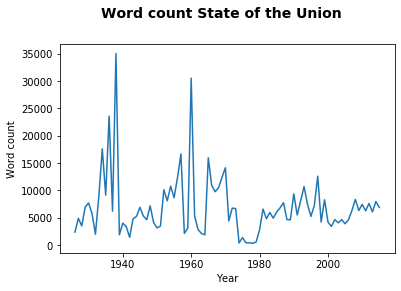

In [26]:
fig = plt.figure();
stats.iloc[3].plot.line()
fig.suptitle('Word count State of the Union', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')


### El conteo de algunas palabras podría ser interesante. Por ejemplo, veamos como evolucionan palabras como 'mercado', 'social', 'familia', 'estado', y 'mujer'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a prev

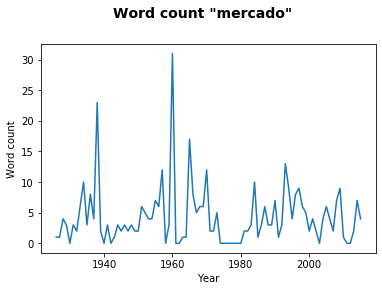

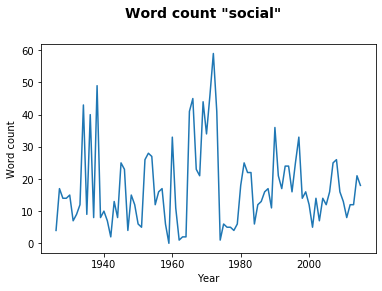

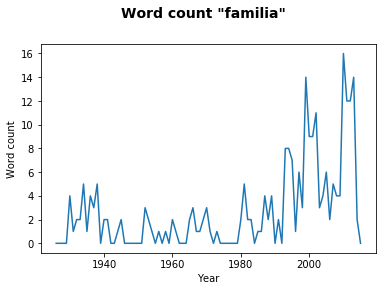

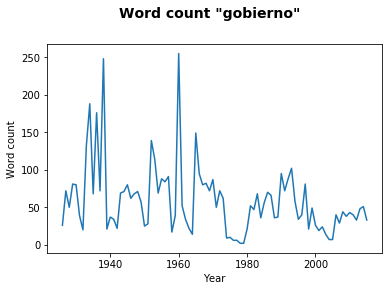

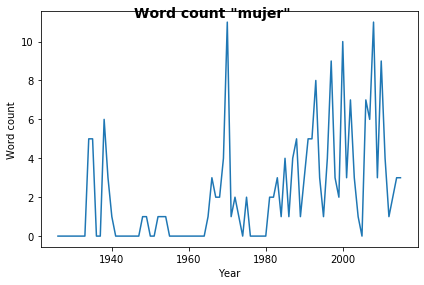

In [27]:
word_1 = dtm_pandas.loc[dtm_pandas['words'] == 'mercado'].drop('words', 1)
word_2 = dtm_pandas.loc[dtm_pandas['words'] == 'social'].drop('words', 1)
word_3 = dtm_pandas.loc[dtm_pandas['words'] == 'familia'].drop('words', 1)
word_4 = dtm_pandas.loc[dtm_pandas['words'] == 'gobierno'].drop('words', 1)
word_5 = dtm_pandas.loc[dtm_pandas['words'] == 'mujer'].drop('words', 1)

fig_1 = plt.figure();
word_1.iloc[0].plot.line()
fig_1.suptitle('Word count "mercado"', fontsize=14, fontweight='bold')

ax = fig_1.add_subplot(111)
fig_1.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')


fig_2 = plt.figure();
word_2.iloc[0].plot.line()
fig_2.suptitle('Word count "social"', fontsize=14, fontweight='bold')

ax = fig_2.add_subplot(111)
fig_2.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')

fig_3 = plt.figure();
word_3.iloc[0].plot.line()
fig_3.suptitle('Word count "familia"', fontsize=14, fontweight='bold')

ax = fig_3.add_subplot(111)
fig_3.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')

fig_4 = plt.figure();
word_4.iloc[0].plot.line()
fig_4.suptitle('Word count "gobierno"', fontsize=14, fontweight='bold')

ax = fig_4.add_subplot(111)
fig_4.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')

fig_5 = plt.figure();
word_5.iloc[0].plot.line()
fig_5.suptitle('Word count "mujer"', fontsize=14, fontweight='bold')

ax = fig_5.add_subplot(111)
fig_5.subplots_adjust(top=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Word count')
plt.savefig('../results/wordcount_mujer.png', dpi = 600)
plt.tight_layout()


### Hacemos un ejercicio de clusterización:

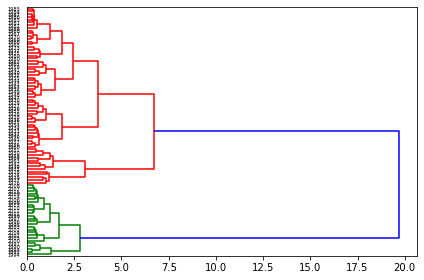

In [28]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

dendrogram(linkage_matrix, orientation="right", labels=names)
plt.tight_layout() 

plt.savefig('../results/clustering.png', dpi = 600)
plt.show()

### Al igual que en el primer gráfico de distancia entre discursos, tenemos demasiada información en este gráfico. Nuevamente repetimos por presidente. 

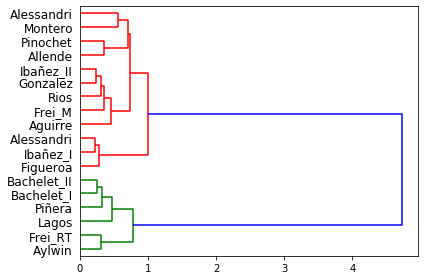

In [29]:
linkage_matrix = ward(dist_2)

dendrogram(linkage_matrix, orientation="right", labels=names_presidents)
plt.tight_layout()
plt.savefig('../results/clustering_presidents.png', dpi = 600)
plt.show()

### La clusterización es interesante porque entrega resultados similares al gráfico de distancia entre discursos. Como se puede ver, en un cluster tenemos los 4 últimos presidentes. 

# Topic Modeling
### Para concluir hacemos un ejercicio de clasificación para identificar los temas que más se repiten en los discursos. El modelo usado es LDA (Latent-Dirichlet Allocation).

In [30]:
import lda

In [31]:
#este método es intensivo en operación, por lo que este bloque tarda alrededor de 1 minuto en mi laptop
model = lda.LDA(n_topics=10, n_iter=1000, random_state=1)

model.fit(dtm.transpose())

topic_word = model.topic_word_
n_top_words = 10

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 90
INFO:lda:vocab_size: 35736
INFO:lda:n_words: 625259
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -7273326
INFO:lda:<10> log likelihood: -6188744
INFO:lda:<20> log likelihood: -5896438
INFO:lda:<30> log likelihood: -5800448
INFO:lda:<40> log likelihood: -5753256
INFO:lda:<50> log likelihood: -5724590
INFO:lda:<60> log likelihood: -5707256
INFO:lda:<70> log likelihood: -5694368
INFO:lda:<80> log likelihood: -5685263
INFO:lda:<90> log likelihood: -5677635
INFO:lda:<100> log likelihood: -5669082
INFO:lda:<110> log likelihood: -5663285
INFO:lda:<120> log likelihood: -5659231
INFO:lda:<130> log likelihood: -5657872
INFO:lda:<140> log likelihood: -5655476
INFO:lda:<150> log likelihood: -5652969
INFO:lda:<160> log likelihood: -5651772
INFO:lda:<170> log likelihood: -5651005
INFO:lda:<180> log likelihood: -5650185
INFO:lda:<190> log likelihood: -5649065
INFO:lda:<200> log likelihood: -5649017
INFO:lda:<210> log likelihood: -5647911
INFO:lda:<

Topic 0: gobierno obras desarrollo productos nacional industria proyecto aumento santiago importancia
Topic 1: nacional gobierno estado fuerzas internacional social naciones pueblo orden vida
Topic 2: aa pesos paa ma ley naomero servicios trecientos servicio ta
Topic 3: ma pola paa tica repaoblica ra as economa accian produccian
Topic 4: desarrollo sector recursos social materia programas proyectos infraestructura crecimiento sectores
Topic 5: ley ministerio servicio materia medidas fuerza nacional fomento personal coma
Topic 6: ano anos educacion ley politica personas sistema proyecto quiero calidad
Topic 7: ma aa paa pola tica ta dalares desarrollo sistema ses
Topic 8: programa reforma salud sociedad nacional doscientos forma vivienda coma meses
Topic 9: gobierno estado vida congreso intereses recursos actual necesidad problema leyes


### Se pueden identificar los topic principales, y también podemos ver la evolución de estos, información que está guardada en el objeto 'model'. Grafiquemos la evolución del topic 3 por mencionar palabras como 'democracia', 'futuro', 'desarrollo', y 'empresas'.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


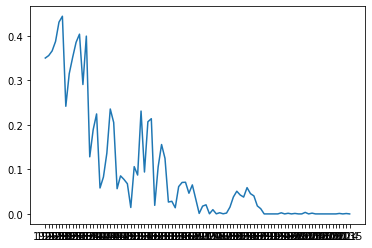

In [32]:
plt.plot(sorted(names), model.doc_topic_[:,2])
plt.savefig('../results/topic2.png', dpi = 600)
plt.show()

### Leemos los datos de pib per cápita

In [33]:
gdppc = pd.read_csv('../data/gdppc1926.csv', names = ['gdppc'])
gdppc = gdppc.drop(gdppc.index[[0]])
gdppc['gdppc'] = gdppc['gdppc'].astype(float)
gdppc.head()

,gdppc
1926,856627.0
1927,828069.0
1928,1022400.0
1929,1036222.0
1930,890724.0


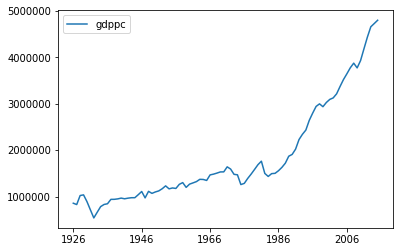

In [34]:
gdppc.plot(kind='line')
plt.show()

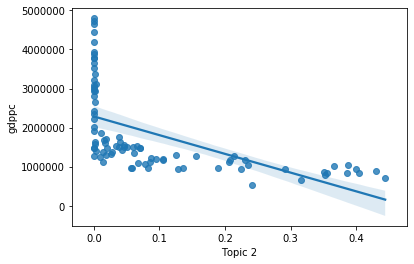

In [35]:
import seaborn as sns
gdppc['Topic 2'] = model.doc_topic_[:,2]
sns.regplot(x = gdppc['Topic 2'], y = gdppc['gdppc'] )
plt.savefig('../results/reg_plot.png', dpi = 600)